In [1]:
import os
import numpy as np
import pandas as pd
import compress_json
from glob import glob
from typing import Dict
import matplotlib.pyplot as plt
from humanize import naturaldelta
from tqdm.auto import tqdm, trange
from time import perf_counter, sleep
from sanitize_ml_labels import sanitize_ml_labels

# Load the data

In [2]:
import humanize 

def xformat_func(value, tick_number):
    if value == 0:
        return "0s"
    if value < 1e-9:
        return r"${:.2f}ps$".format(value * 1e12)
    if value < 1e-6:
        return r"${:.2f}ns$".format(value * 1e9)
    if value < 1e-3:
        return r"${:.2f}\mu s$".format(value * 1e6)
    if value < 1:
        return r"${:.2f}ms$".format(value * 1e3)
    if value < 60:
        return r"${:.2f}s$".format(value)
    if value < 3600:
        return r"${:.2f}m$".format(value / 60)
    
    return r"${:.2f}h$".format(value / 3600)

def yformat_func(value, tick_number):
    return humanize.naturalsize(value * (1000**3))

In [3]:
files = [
    path
    for path in glob('./graphs/results/**/*.csv', recursive=True)
    if os.path.getsize(path) > 0 and "node2"not in path.lower()
]

In [4]:
reports = pd.DataFrame([
    compress_json.load(report_path)
    for report_path in glob("./graphs/**/report.json", recursive=True)
]).astype({
    "degree_mean":float,
    "density":float,
    "nodes_number":int,
    "undirected_edges_number":int
})

In [15]:
reports

unique_edge_types_number has_weights  undirected_edges_number edges_number  \
0                         0       false                146109300    292218600   
1                         0       false                     3054         6108   
2                         0       false                  4507315      9014630   
3                         0       false                 14506196     28967291   
4                         0       false                 31383583     62767166   
5                         0       false                     9016        17927   
6                         0       false                 15611957     31223434   
7                         0       false                    90811       181622   
8                         0       false                  3782454      7564901   
9                         0        true                   544538      1089076   
10                        0       false                 12345963     24669643   
11                        0       false                  2093195      4186390   

   unique_node_types_number directed has_node_types  degree_mean  \
0                         0    false          false   299.425778   
1                         0    false          false    25.239669   
2                         0    false          false     4.835052   
3                         0    false          false   642.276025   
4                         0    false          false    26.081739   
5                         0    false          false    10.065693   
6                         0    false          false    71.057470   
7                         0    false          false   168.793680   
8                         0    false          false     8.440097   
9                         0    false          false    67.758104   
10                        0    false          false  1107.106000   
11                        0    false          false    47.152527   

                           name has_edge_types singletons  \
0                 bn-human-Jung          false          0   
1     bn-macaque-rhesus-brain-1          false          0   
2                     Wikipedia          false          0   
3                bio-mouse-gene          false          0   
4                         Flikr          false          0   
5   bn-fly-drosophila-medulla-1          false          0   
6                   KG-COVID-19          false          0   
7             bn-mouse_retina-1          false          0   
8                          IMDB          false          0   
9                     StringPPI          false          0   
10               bio-human-gene          false          0   
11                  BlogCatalog          false          0   

             self_loops_rate   density  nodes_number self_loops_number  
0                          0  0.089896        975930                 0  
1                          0  0.104729           242                 0  
2                          0  0.006091       1864433                 0  
3      0.0015569629897390128  0.014241         45101             45101  
4                          0  0.033149       2406556                 0  
5       0.005857087075361187  0.005655          1781               105  
6    0.000015373068830289457  0.007610        439411               480  
7                          0  0.157017          1076                 0  
8   0.0000009253260551592149  0.037289        896305                 7  
9                          0  0.004216         16073                 0  
10     0.0009032558760578741  0.049686         22283             22283  
11                         0  0.001167         88784                 0

In [16]:
execs_type = {}
result = pd.DataFrame()
for file in files:
    if "wikipedia" in file.lower():
        continue
    # From the path extract the infos
    *_, graph, library, task = file.split("/")
    # Load the file
    df = pd.read_csv(file, usecols=[0,1], dtype={
        "time":float,
        "memory":float
    })
    df.columns = ["time", "memory"]
    df["name"] = graph
    df["library"] = library
    df["task"] = task.split(".")[0]
    
    # Check if the experiment was killed
    last_row = df.iloc[-1]
    if last_row.time == -1 and last_row.memory == -1:
        exec_type = "exception"
        df = df.head(-2)
    elif last_row.time == 0 and last_row.memory== 0:
        exec_type = "ok"
        df = df.head(-1)
    else:
        exec_type = "killed"
        
    execs_type.setdefault(graph, {})
    execs_type[graph].setdefault(library, {})
    execs_type[graph][library][task.split(".")[0]] = exec_type
    
    
    
    # Update the global results
    result = pd.concat([result, df])

result=result.merge(reports, on=["name"])

In [17]:
max_result = result.groupby(["name", "library", "task"]).max().reset_index()

In [18]:
max_result.name.unique()

array(['BlogCatalog', 'Flikr', 'IMDB', 'KG-COVID-19', 'StringPPI',
       'bio-human-gene', 'bio-mouse-gene', 'bn-fly-drosophila-medulla-1',
       'bn-human-Jung', 'bn-macaque-rhesus-brain-1', 'bn-mouse_retina-1'],
      dtype=object)

In [19]:
tasks = ["load_graph", "first_order_walk", "second_order_walk"]

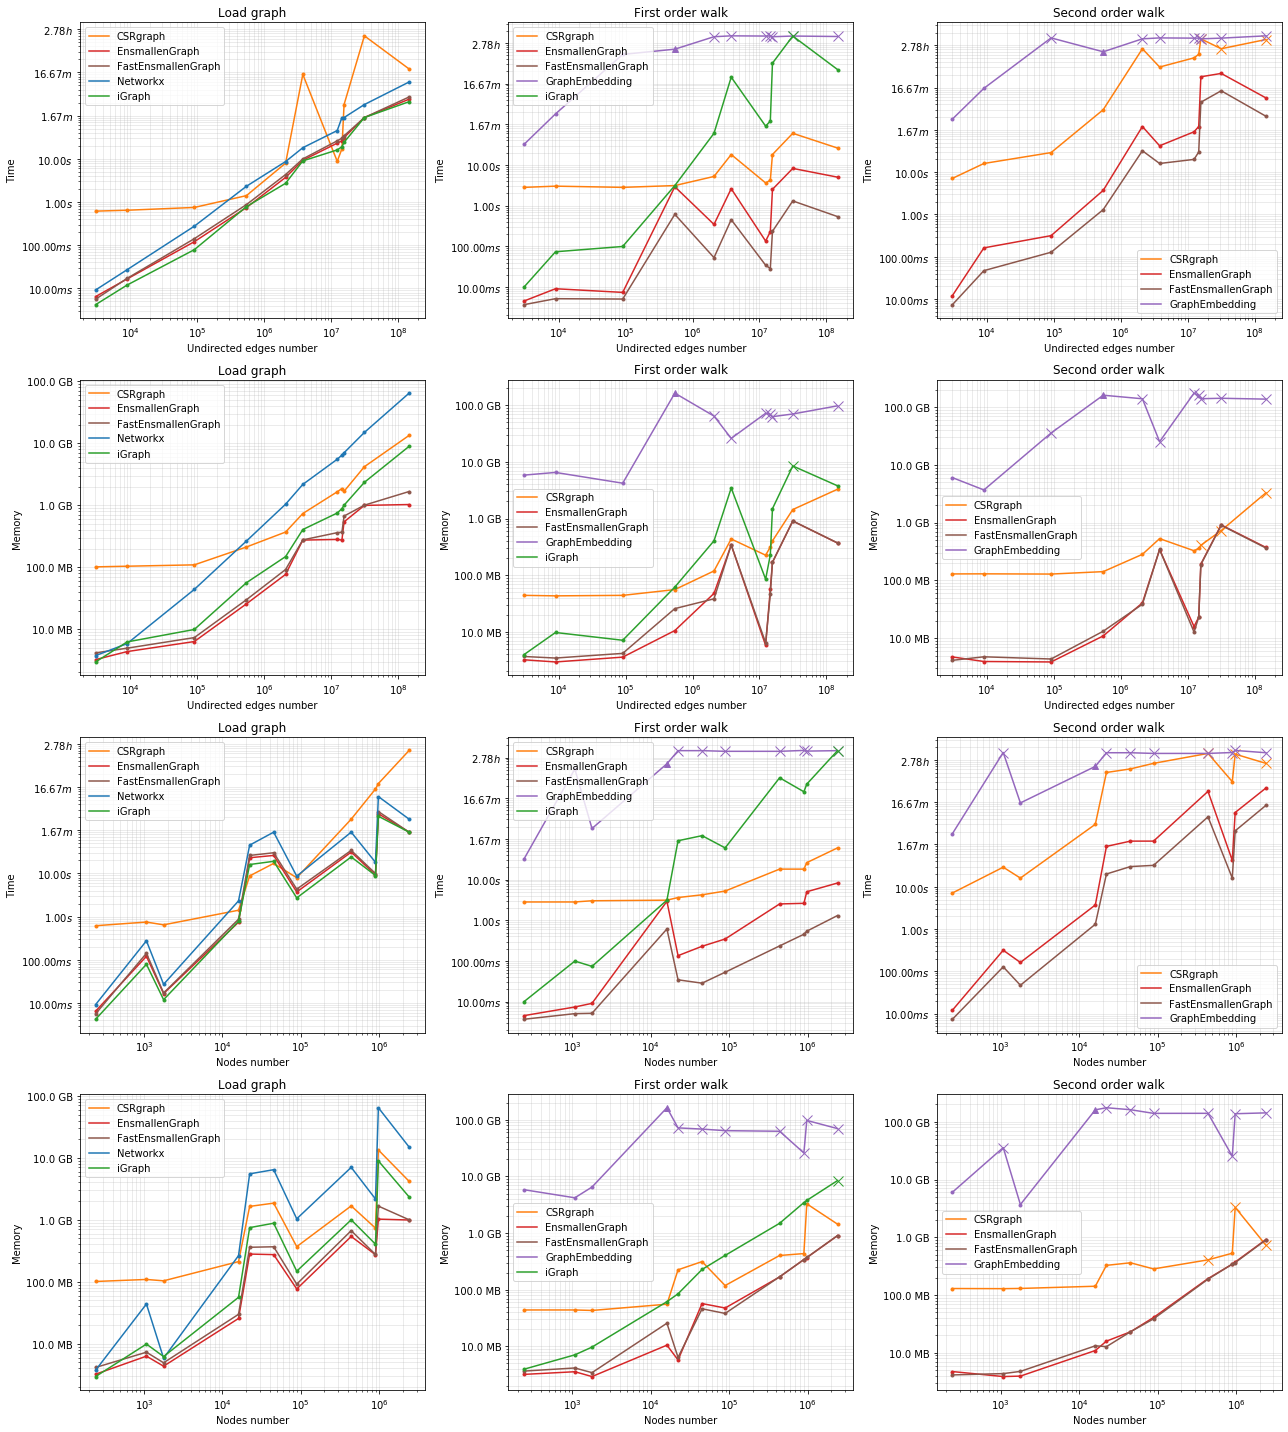

In [20]:
cmap = plt.get_cmap("tab10")
colors = dict(list(zip(result.library.unique(), cmap.colors)))
graphs = max_result.name.unique()
libraries = max_result.library.unique()

fig, axes = plt.subplots(ncols=len(tasks), nrows=4, figsize=(6*len(tasks), 20), squeeze=False)

for library in libraries:
    for i, task in enumerate(tasks):
        data = max_result[
            (max_result.library == library) &
            (max_result.task == task)
        ]
        if data.empty:
            continue
        pos = 0
        for k, number in enumerate(("undirected_edges_number", "nodes_number")):
            for j, (column, format_func) in enumerate((("time", xformat_func), ("memory", yformat_func))):
                axis = axes[pos, i]
                pos+=1
                axis.grid(True, which="both", ls="-", alpha=0.3)
                sorted_data = data.sort_values(by=[number])
                axis.plot(sorted_data[number], sorted_data[column], label=library, c=colors[library])
                for graph in graphs:
                    graph_data = data[data.name==graph]
                    exec_type = execs_type[graph][library][task]
                    x = graph_data[number]
                    y = graph_data[column]
                    if exec_type == "killed":
                        axis.plot([x], [y], marker="x", c=colors[library], markersize=10)
                    elif exec_type == "exception":
                        axis.plot([x], [y], marker="^", c=colors[library])
                    else:
                        axis.plot([x], [y], marker=".", c=colors[library])
                axis.set_ylabel(sanitize_ml_labels(column))
                axis.set_xlabel(sanitize_ml_labels(number))
                axis.set_xscale("log")
                axis.set_yscale("log")
                axis.set_title(sanitize_ml_labels(task))
                axis.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
                axis.legend()
fig.tight_layout()
plt.show()

### Plot RAM over time for each task and each graph

In [21]:
def legend_without_duplicate_labels(fig, axes, **kwargs):
    labels_set = set()
    uniques = []
    for row in axes:
        for ax in row:
            handles, labels = ax.get_legend_handles_labels()
            axis_unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            for (h, l) in axis_unique:
                if l not in labels_set:
                    labels_set.add(l)
                    uniques.append((h, l))
    ax.legend(*zip(*uniques), **kwargs)

In [22]:
result

time    memory            name             library        task  \
0       0.000206  0.002993     KG-COVID-19            Networkx  load_graph   
1       0.000366  0.002993     KG-COVID-19            Networkx  load_graph   
2       0.000478  0.002993     KG-COVID-19            Networkx  load_graph   
3       0.000572  0.002993     KG-COVID-19            Networkx  load_graph   
4       0.000662  0.002993     KG-COVID-19            Networkx  load_graph   
...          ...       ...             ...                 ...         ...   
99111  22.058445  0.280357  bio-human-gene  FastEnsmallenGraph  load_graph   
99112  23.059925  0.308715  bio-human-gene  FastEnsmallenGraph  load_graph   
99113  24.061367  0.334911  bio-human-gene  FastEnsmallenGraph  load_graph   
99114  25.062795  0.360626  bio-human-gene  FastEnsmallenGraph  load_graph   
99115  26.064307  0.267379  bio-human-gene  FastEnsmallenGraph  load_graph   

      unique_edge_types_number has_weights  undirected_edges_number  \
0                            0       false                 15611957   
1                            0       false                 15611957   
2                            0       false                 15611957   
3                            0       false                 15611957   
4                            0       false                 15611957   
...                        ...         ...                      ...   
99111                        0       false                 12345963   
99112                        0       false                 12345963   
99113                        0       false                 12345963   
99114                        0       false                 12345963   
99115                        0       false                 12345963   

      edges_number unique_node_types_number directed has_node_types  \
0         31223434                        0    false          false   
1         31223434                        0    false          false   
2         31223434                        0    false          false   
3         31223434                        0    false          false   
4         31223434                        0    false          false   
...            ...                      ...      ...            ...   
99111     24669643                        0    false          false   
99112     24669643                        0    false          false   
99113     24669643                        0    false          false   
99114     24669643                        0    false          false   
99115     24669643                        0    false          false   

       degree_mean has_edge_types singletons          self_loops_rate  \
0         71.05747          false          0  0.000015373068830289457   
1         71.05747          false          0  0.000015373068830289457   
2         71.05747          false          0  0.000015373068830289457   
3         71.05747          false          0  0.000015373068830289457   
4         71.05747          false          0  0.000015373068830289457   
...            ...            ...        ...                      ...   
99111   1107.10600          false          0    0.0009032558760578741   
99112   1107.10600          false          0    0.0009032558760578741   
99113   1107.10600          false          0    0.0009032558760578741   
99114   1107.10600          false          0    0.0009032558760578741   
99115   1107.10600          false          0    0.0009032558760578741   

        density  nodes_number self_loops_number  
0      0.007610        439411               480  
1      0.007610        439411               480  
2      0.007610        439411               480  
3      0.007610        439411               480  
4      0.007610        439411               480  
...         ...           ...               ...  
99111  0.049686         22283             22283  
99112  0.049686         22283             22283  
99113  0.049686         22283             

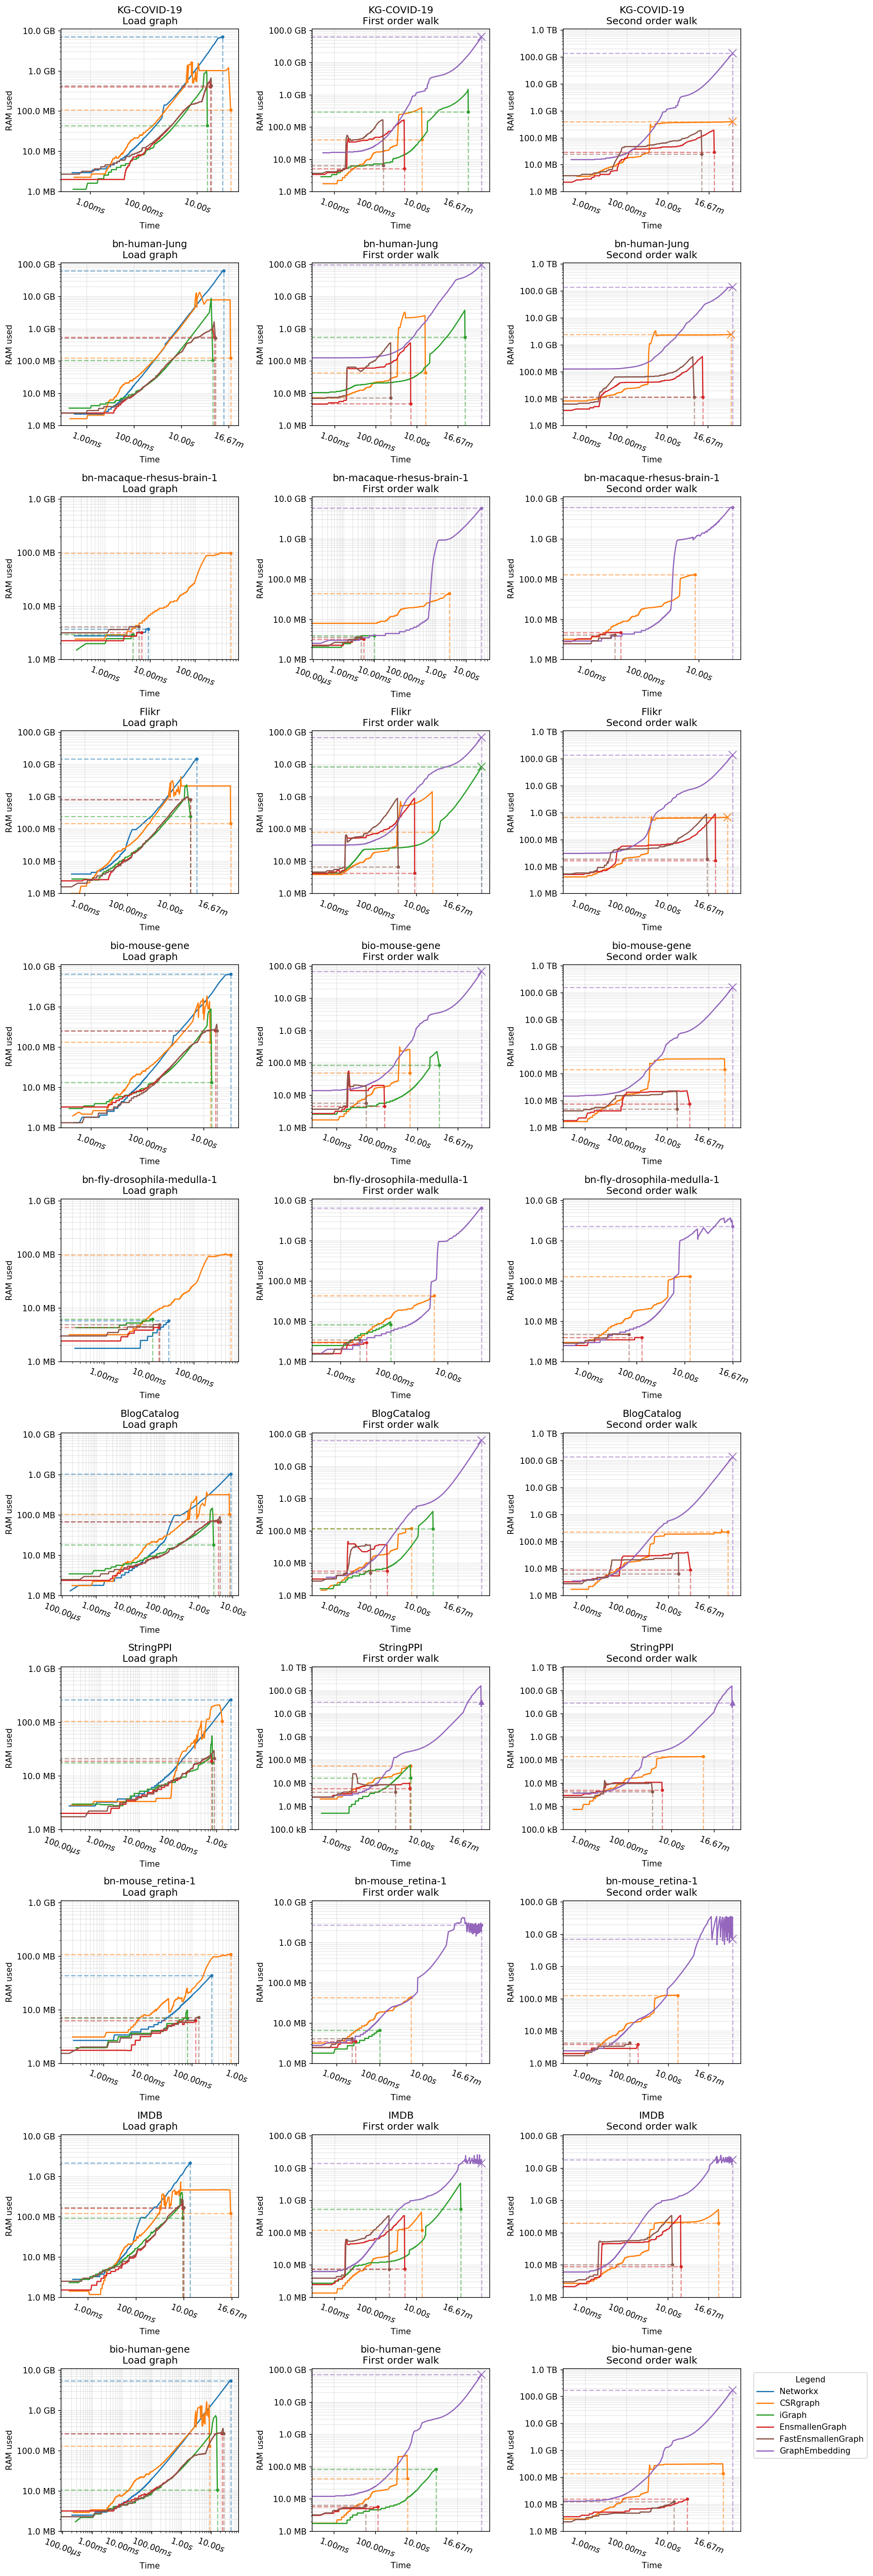

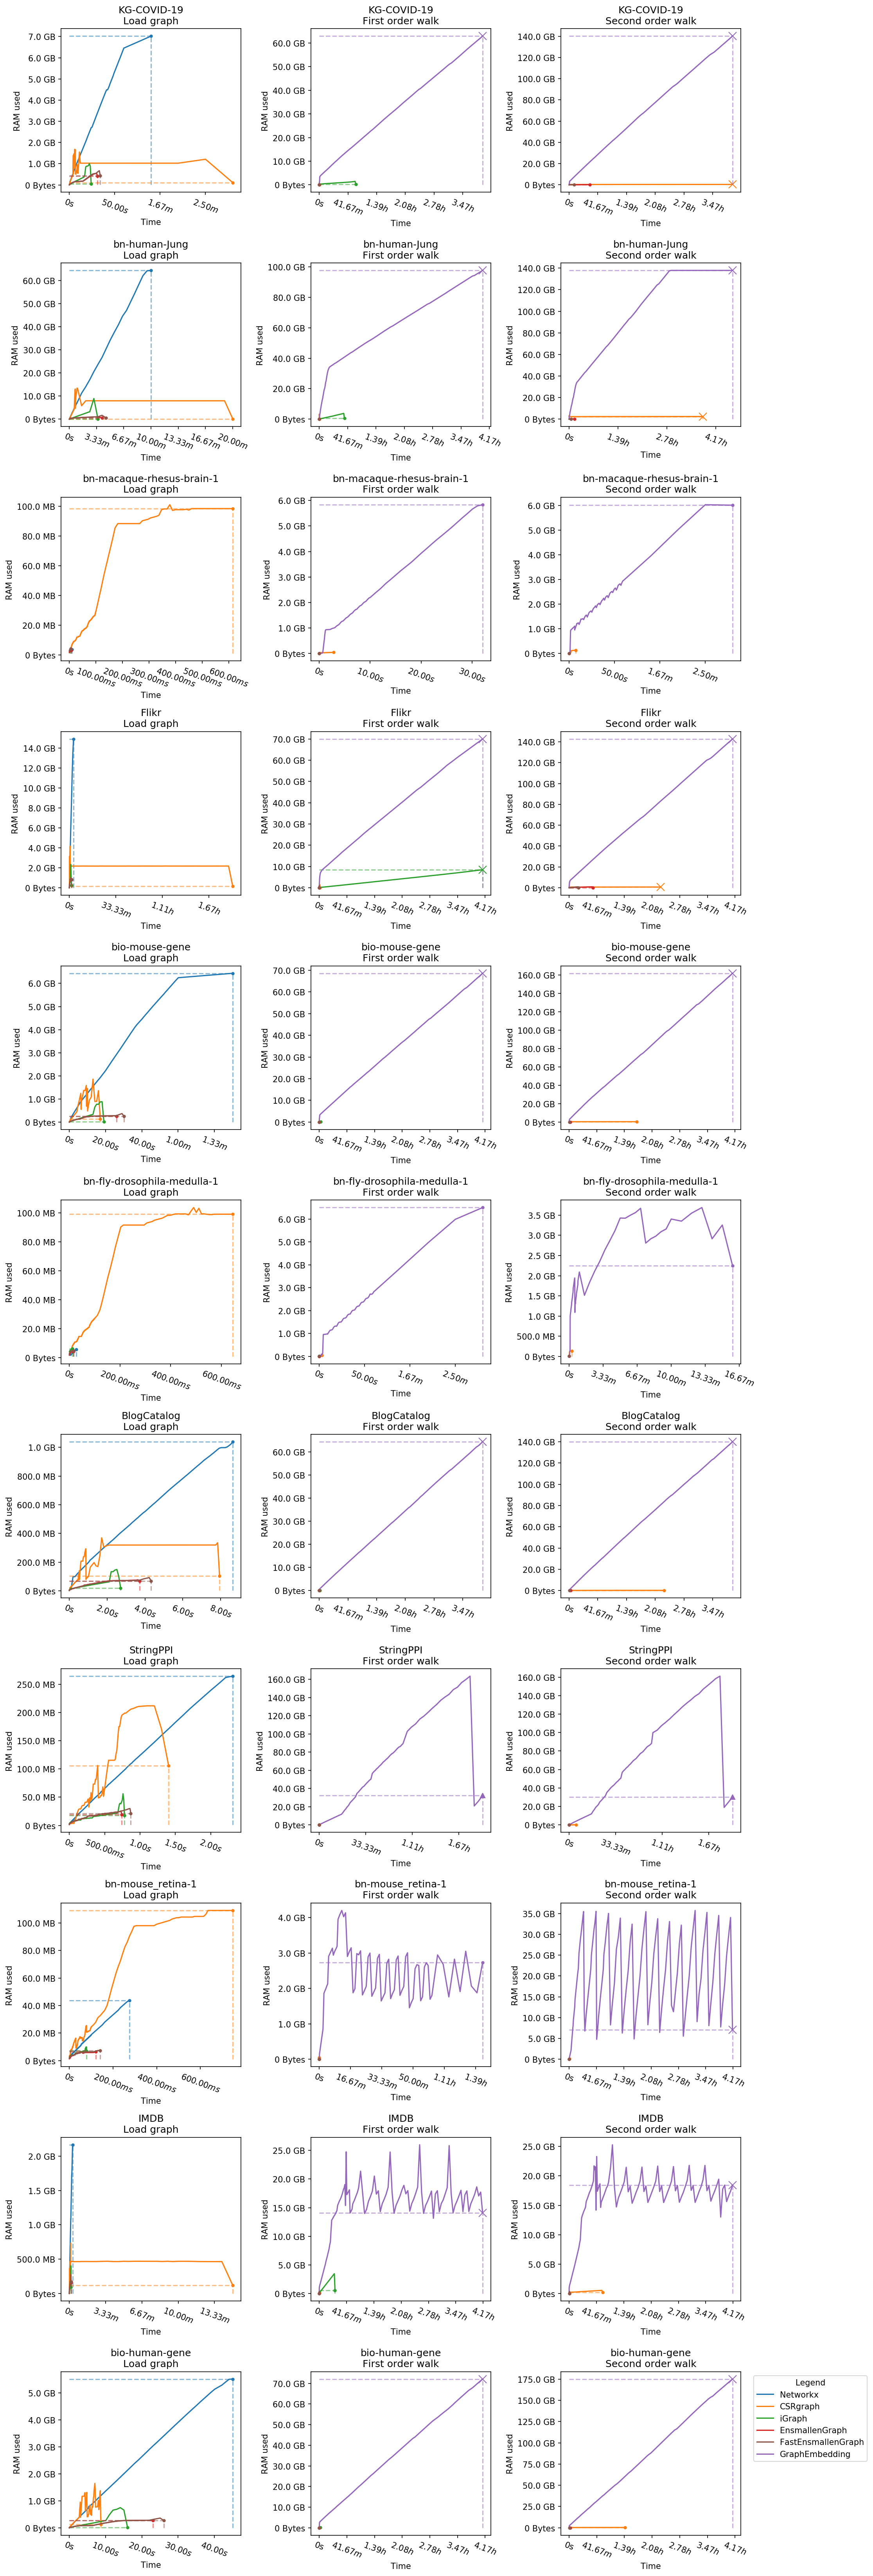

In [23]:
ncols=len(result.task.unique())
nrows=len(result.name.unique())
    

for log in [True, False]:
    fig, axes = plt.subplots(
        dpi=150,
        ncols=ncols,
        nrows=nrows,
        squeeze=False,
        figsize=(5*ncols, 4*nrows)
    )
    for graph, sub_axes in zip(result.name.unique(), axes):
        for task, axis in zip(tasks, sub_axes):
            all_data = result[(result.name==graph) & (result.task==task)]
            max_y = 10**np.ceil(np.log10(all_data.memory.max()))
            min_y = all_data.memory.min()
            if min_y < 0.0001:
                min_y = 0.0001
                
            min_y = 10**np.floor(np.log10(min_y))
            max_x = all_data.time.max()
            min_x = all_data.time.min()
            for library in result.library.unique():
                # get the data for this triple (graph, task, library)
                filtered = all_data[(all_data.library==library)]
                if len(filtered):
                    # Plot the graph
                    axis.plot(filtered.time, filtered.memory, label=sanitize_ml_labels(library), c=colors[library])
                    x, y = filtered.time.iloc[-1], filtered.memory.iloc[-1]
                    # add the termination marker
                    exec_type = execs_type[graph][library][task]
                    if exec_type == "killed":
                        axis.plot([x], [y], marker="x", c=colors[library], markersize=10)
                    elif exec_type == "exception":
                        axis.plot([x], [y], marker="^", c=colors[library])
                    else:
                        axis.plot([x], [y], marker=".", c=colors[library])
                    # Draw the finish line
                    axis.plot([x, x], [min_y, y], "--", alpha=0.5, c=colors[library])
                    axis.plot([min_x, x], [y, y], "--", alpha=0.5, c=colors[library])
            if log:                    
                if not (np.isnan(min_y) or np.isnan(max_y)):
                    axis.set_ylim([min_y, max_y*1.1])
                axis.set_yscale('log')
                axis.set_xscale('log')
                axis.grid(True, which="both", ls="-", alpha=0.3)
            
            axis.set_xlabel("Time")
            axis.set_ylabel("RAM used")
            axis.xaxis.set_tick_params(rotation=-20)
            axis.xaxis.set_major_formatter(plt.FuncFormatter(xformat_func))
            axis.yaxis.set_major_formatter(plt.FuncFormatter(yformat_func))
            axis.set_title("{graph}\n{task}".format(
                graph=graph,
                task=sanitize_ml_labels(task)
            ))
            
                
    legend_without_duplicate_labels(fig, axes, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.tight_layout()
    fig.set_facecolor('w')